In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [49]:
import cactas as C

In [3]:
import tensorflow as tf
import os
import nrrd
import pickle

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA_ESUS35/'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
len(images), len(labels), len(masks)

(70, 70, 70)

In [8]:
numbers = []
for filename in images:
    number = filename.split(".")[0]
    numbers.append(number)

label_dict = {}
for filename in labels:
    num = filename.split(".")[0]
    label_dict[num] = filename

mask_dict = {}
for filename in masks:
    num = filename.split(".")[0]
    mask_dict[num] = filename

data = []
for filename in images:
    number = filename.split(".")[0]
    data.append((filename, label_dict[number], mask_dict[number]))

random.shuffle(data)

images = [item[0] for item in data]
labels = [item[1] for item in data]
masks = [item[2] for item in data]

In [9]:
X_train = []
y_train = []
m_train = []

In [10]:
for file in images:
    data, header = nrrd.read(DATAPATH + "/" +file)
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    X_train.append(normalized_data)

In [11]:
for file in labels:
    data, header = nrrd.read(DATAPATH + "/" +file)
    y_train.append(normalized_data)

In [12]:
for file in masks:
    data, header = nrrd.read(CAPATH + "/" +file)
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    m_train.append(normalized_data)

In [13]:
len(X_train), len(y_train), len(m_train)

(70, 70, 70)

In [14]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key_fulldata(y_train)

13495


In [15]:
# Image
slices = []
for i in range(len(X_train)):
    for z in range(X_train[i].shape[2]):
        slice_2d = X_train[i][:, :, z]
        slices.append(slice_2d)
X_train_array = np.array(slices)

In [16]:
# Mask
slices_mtrain=[]
for i in range(len(m_train)):
    for z in range(m_train[i].shape[2]):
        slice_2d = m_train[i][:, :, z]
        slices_mtrain.append(slice_2d)
m_train_array = np.array(slices_mtrain)

In [17]:
X_train_array = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1],X_train_array.shape[2], 1)
m_train_array = m_train_array.reshape(m_train_array.shape[0], m_train_array.shape[1],m_train_array.shape[2], 1)

In [18]:
print(X_train_array.shape, m_train_array.shape)

(16766, 512, 512, 1) (16766, 512, 512, 1)


In [19]:
X_train_set = X_train_array[:last_key]
y_train_set = m_train_array[:last_key]
X_val = X_train_array[last_key:]
y_val = m_train_array[last_key:]

In [20]:
X_train_set.dtype, y_train_set.dtype, X_val.dtype, y_val.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [21]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-09-27 04:30:47.122717: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-09-27 04:30:47.796041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0f:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.39GiB deviceMemoryBandwidth: 1.41TiB/s
2024-09-27 04:30:47.805617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:bd:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.39GiB deviceMemoryBandwidth: 1.41TiB/s
2024-09-27 04:30:47.805642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-09-27 04:30:47.830250: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

In [22]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-09-27 04:31:05.385534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-09-27 04:31:05.406565: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245750000 Hz


Epoch 1/200


2024-09-27 04:31:07.052491: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-09-27 04:31:07.818178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-09-27 04:31:08.850221: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-09-27 04:31:08.850245: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-09-27 04:31:08.850608: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-09-27 04:31:08.932399: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-09-27 04:31:09.887436: I tensorflow/stream_exec

843/843 [==============================] - 403s 463ms/step - loss: 0.0819 - iou: 5.3637e-04 - iou_thresholded: 0.0851 - val_loss: 0.0058 - val_iou: 3.4562e-04 - val_iou_thresholded: 0.7919
Epoch 2/200
843/843 [==============================] - 388s 457ms/step - loss: 0.0036 - iou: 0.0027 - iou_thresholded: 0.1069 - val_loss: 0.0042 - val_iou: 8.4396e-04 - val_iou_thresholded: 0.8245
Epoch 3/200
843/843 [==============================] - 384s 455ms/step - loss: 0.0028 - iou: 0.0111 - iou_thresholded: 0.1128 - val_loss: 0.0036 - val_iou: 0.0037 - val_iou_thresholded: 0.8245
Epoch 4/200
843/843 [==============================] - 385s 456ms/step - loss: 0.0025 - iou: 0.0229 - iou_thresholded: 0.1017 - val_loss: 0.0043 - val_iou: 9.3873e-04 - val_iou_thresholded: 0.8245
Epoch 5/200
843/843 [==============================] - 385s 456ms/step - loss: 0.0023 - iou: 0.0365 - iou_thresholded: 0.1102 - val_loss: 0.0034 - val_iou: 0.0141 - val_iou_thresholded: 0.6628
Epoch 6/200
843/843 [==========

Epoch 43/200
843/843 [==============================] - 382s 453ms/step - loss: 3.3175e-04 - iou: 0.5364 - iou_thresholded: 0.7168 - val_loss: 0.0050 - val_iou: 0.0672 - val_iou_thresholded: 0.7176
Epoch 44/200
843/843 [==============================] - 382s 453ms/step - loss: 3.1190e-04 - iou: 0.5594 - iou_thresholded: 0.7281 - val_loss: 0.0048 - val_iou: 0.1221 - val_iou_thresholded: 0.7390
Epoch 45/200
843/843 [==============================] - 382s 453ms/step - loss: 2.9115e-04 - iou: 0.5710 - iou_thresholded: 0.7392 - val_loss: 0.0057 - val_iou: 0.1256 - val_iou_thresholded: 0.7323
Epoch 46/200
843/843 [==============================] - 382s 453ms/step - loss: 4.2416e-04 - iou: 0.5173 - iou_thresholded: 0.6798 - val_loss: 0.0049 - val_iou: 0.0732 - val_iou_thresholded: 0.7959
Epoch 47/200
843/843 [==============================] - 382s 453ms/step - loss: 2.8796e-04 - iou: 0.5743 - iou_thresholded: 0.7387 - val_loss: 0.0051 - val_iou: 0.1397 - val_iou_thresholded: 0.7247
Epoch 48/2

843/843 [==============================] - 383s 454ms/step - loss: 1.6754e-04 - iou: 0.7053 - iou_thresholded: 0.8424 - val_loss: 0.0059 - val_iou: 0.2227 - val_iou_thresholded: 0.7504
Epoch 85/200
843/843 [==============================] - 383s 454ms/step - loss: 1.6472e-04 - iou: 0.7296 - iou_thresholded: 0.8513 - val_loss: 0.0061 - val_iou: 0.2669 - val_iou_thresholded: 0.7141
Epoch 86/200
843/843 [==============================] - 383s 454ms/step - loss: 1.7798e-04 - iou: 0.7137 - iou_thresholded: 0.8382 - val_loss: 0.0060 - val_iou: 0.2329 - val_iou_thresholded: 0.7091
Epoch 87/200
843/843 [==============================] - 383s 454ms/step - loss: 1.4106e-04 - iou: 0.7401 - iou_thresholded: 0.8615 - val_loss: 0.0066 - val_iou: 0.3324 - val_iou_thresholded: 0.7542
Epoch 88/200
843/843 [==============================] - 384s 455ms/step - loss: 1.6298e-04 - iou: 0.7262 - iou_thresholded: 0.8431 - val_loss: 0.0059 - val_iou: 0.2838 - val_iou_thresholded: 0.7208
Epoch 89/200
843/843 [=

843/843 [==============================] - 384s 455ms/step - loss: 1.1897e-04 - iou: 0.7833 - iou_thresholded: 0.8910 - val_loss: 0.0068 - val_iou: 0.4286 - val_iou_thresholded: 0.7434
Epoch 126/200
843/843 [==============================] - 384s 456ms/step - loss: 1.0810e-04 - iou: 0.8056 - iou_thresholded: 0.9000 - val_loss: 0.0062 - val_iou: 0.3234 - val_iou_thresholded: 0.7511
Epoch 127/200
843/843 [==============================] - 384s 455ms/step - loss: 1.1374e-04 - iou: 0.8020 - iou_thresholded: 0.8920 - val_loss: 0.0070 - val_iou: 0.3833 - val_iou_thresholded: 0.7492
Epoch 128/200
843/843 [==============================] - 384s 455ms/step - loss: 1.0703e-04 - iou: 0.7994 - iou_thresholded: 0.8936 - val_loss: 0.0073 - val_iou: 0.4381 - val_iou_thresholded: 0.7758
Epoch 129/200
843/843 [==============================] - 383s 454ms/step - loss: 1.0207e-04 - iou: 0.8147 - iou_thresholded: 0.8994 - val_loss: 0.0063 - val_iou: 0.4589 - val_iou_thresholded: 0.7520
Epoch 130/200
843/8

843/843 [==============================] - 383s 455ms/step - loss: 9.0764e-05 - iou: 0.8209 - iou_thresholded: 0.9055 - val_loss: 0.0064 - val_iou: 0.4765 - val_iou_thresholded: 0.7606
Epoch 167/200
843/843 [==============================] - 384s 455ms/step - loss: 9.4091e-05 - iou: 0.8353 - iou_thresholded: 0.9115 - val_loss: 0.0069 - val_iou: 0.5394 - val_iou_thresholded: 0.7662
Epoch 168/200
843/843 [==============================] - 384s 455ms/step - loss: 1.1685e-04 - iou: 0.8155 - iou_thresholded: 0.9042 - val_loss: 0.0065 - val_iou: 0.4988 - val_iou_thresholded: 0.7600
Epoch 169/200
843/843 [==============================] - 384s 455ms/step - loss: 8.9610e-05 - iou: 0.8307 - iou_thresholded: 0.9130 - val_loss: 0.0064 - val_iou: 0.4833 - val_iou_thresholded: 0.7597
Epoch 170/200
843/843 [==============================] - 382s 453ms/step - loss: 9.0419e-05 - iou: 0.8382 - iou_thresholded: 0.9147 - val_loss: 0.0068 - val_iou: 0.4956 - val_iou_thresholded: 0.7578
Epoch 171/200
843/8

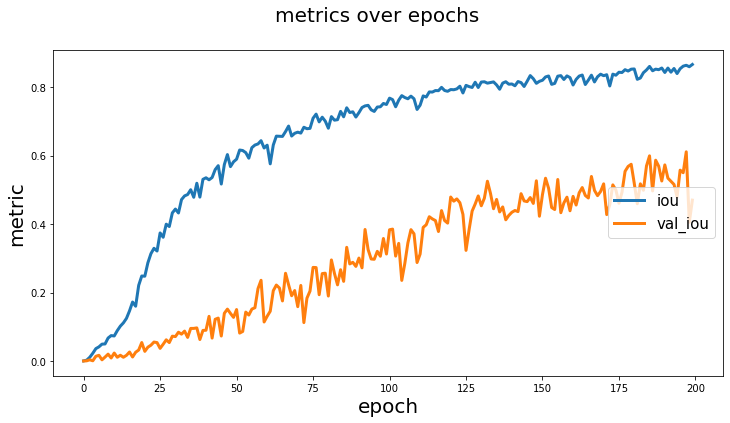

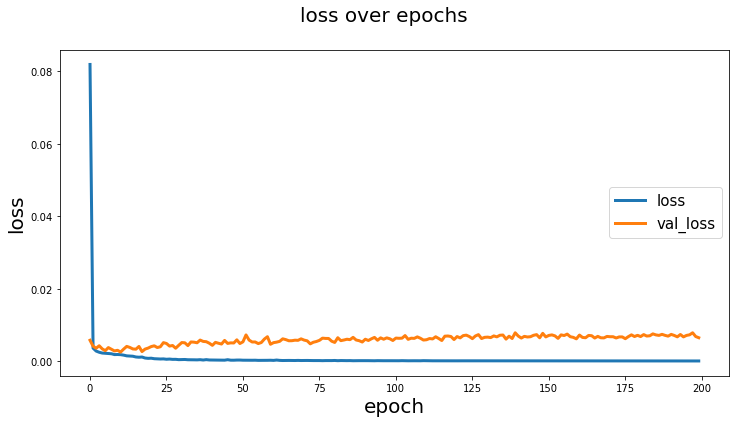

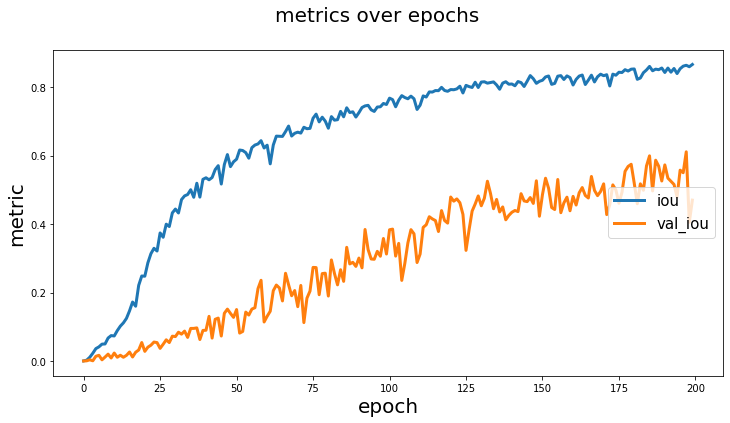

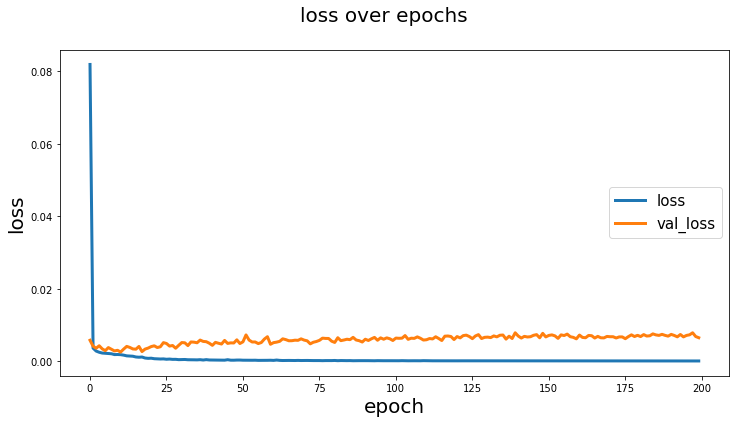

In [23]:
C.Helper.visualize_graph(history)

In [24]:
model.save('/raid/mpsych/CACTAS/DATA/unet_model_v1.h5')

In [25]:
####### TEST using VASCUCAP GT ###########

In [26]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
VASCUPATH='/raid/mpsych/CACTAS/DATA/ELUCID'

In [27]:
images, labels = C.Helper.load_data(DATAPATH)
v_masks = C.Helper.load_seg_data(VASCUPATH)

In [28]:
matched_images = []
v_numbers = [filename.split(".")[0] for filename in v_masks]

In [29]:
for num in v_numbers:
    for img in images:
        if img.startswith(f"{num}.img") or img.startswith(f"{num}.b.img"):
            matched_images.append(img)

In [30]:
X_test = []
m_test = []

In [31]:
for file in matched_images:
    data, header = nrrd.read(DATAPATH + "/" +file)
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    X_test.append(normalized_data)

In [32]:
for file in v_masks:
    data, header = nrrd.read(VASCUPATH + "/" +file)
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    m_test.append(normalized_data)

In [33]:
len(X_test), len(m_test)

(27, 27)

In [34]:
# Image
slices_2 = []
for i in range(len(X_test)):
    for z in range(X_test[i].shape[2]):
        slice_2d = X_test[i][:, :, z]
        slices_2.append(slice_2d)
X_test_array = np.array(slices_2)

In [35]:
# Mask
slices_mtest=[]
for i in range(len(m_test)):
    for z in range(m_test[i].shape[2]):
        slice_2d = m_test[i][:, :, z]
        slices_mtest.append(slice_2d)
m_test_array = np.array(slices_mtest)

In [36]:
X_test_array = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1],X_test_array.shape[2], 1)
m_test_array = m_test_array.reshape(m_test_array.shape[0], m_test_array.shape[1],m_test_array.shape[2], 1)

In [37]:
print(X_test_array.shape, m_test_array.shape)

(6322, 512, 512, 1) (6322, 512, 512, 1)


In [38]:
# from tensorflow.keras.models import load_model
# model = load_model('/raid/mpsych/CACTAS/DATA/unet_model_v1.h5')

In [39]:
y_pred = C.Helper.prediction(X_test_array, model)

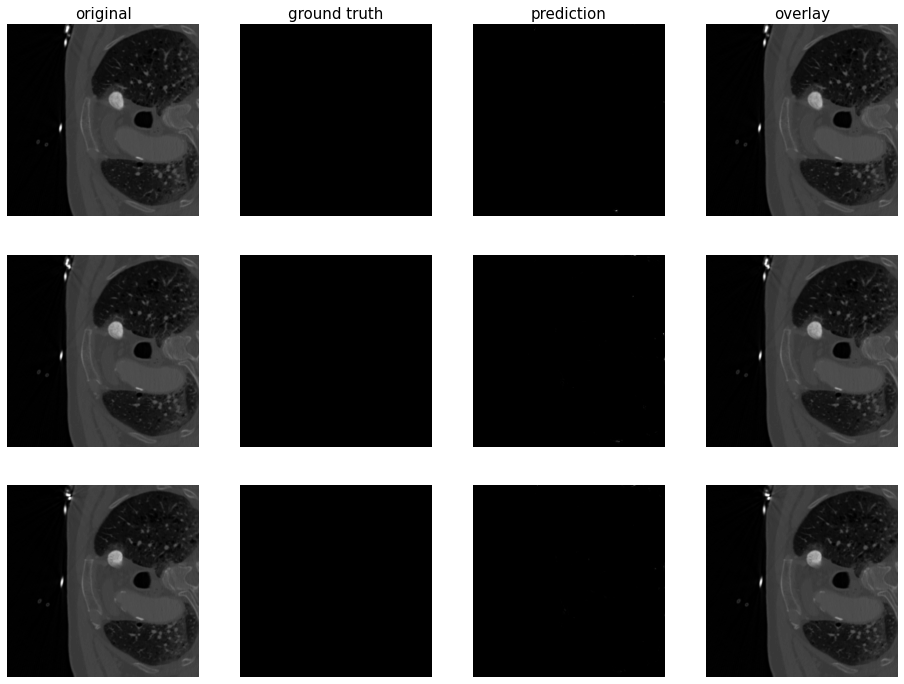

In [40]:
C.Helper.visualize_result(X_test_array, m_test_array, y_pred)

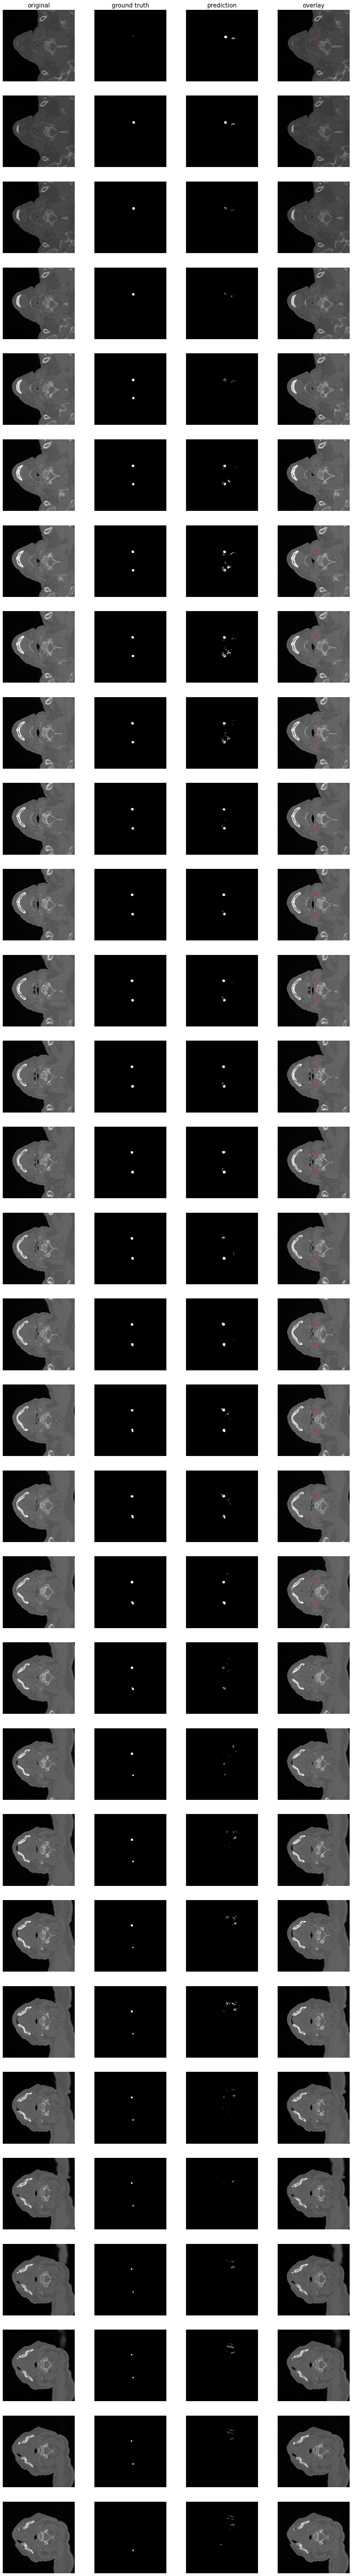

In [41]:
C.Helper.visualize_result_limit(X_test_array, m_test_array, y_pred, start_index=55, end_index=85)

In [50]:
C.Helper.evaluate(X_test_array, m_test_array, model)

198/198 [==============================] - 55s 278ms/step - loss: 0.0013 - iou: 0.4393 - iou_thresholded: 0.7614


(0.0012626921525225043, 0.43934738636016846, 0.7613536715507507)

In [43]:
a = y_pred
a_binary = np.zeros(a.shape, dtype=np.bool_)
a_binary[a > 0.5] = True

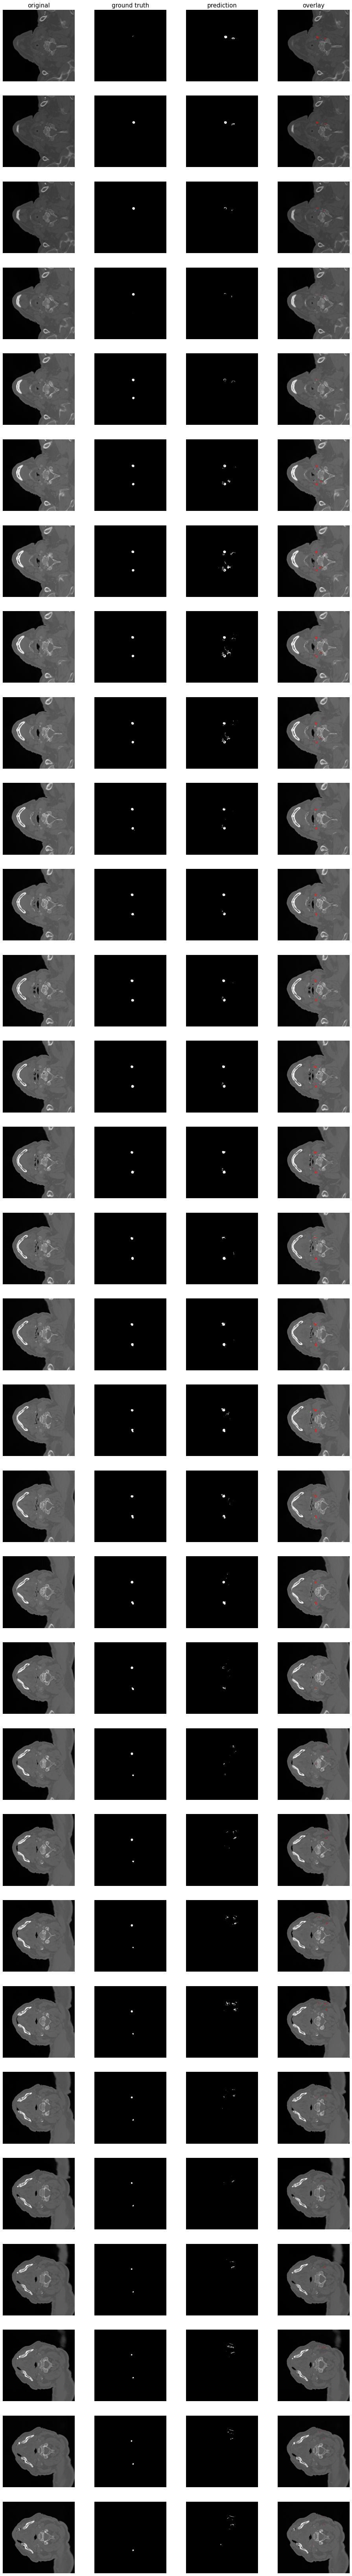

In [44]:
C.Helper.visualize_result_limit(X_test_array, m_test_array, a_binary, start_index=55, end_index=85)

In [51]:
C.Helper.evaluate(X_test_array, a_binary, model)

198/198 [==============================] - 49s 250ms/step - loss: 2.8781e-05 - iou: 0.6236 - iou_thresholded: 1.0000


(2.878103441616986e-05, 0.6235952377319336, 1.0)